### Now there is the time for ResNet. Again we will train the two models separately. The reason is again related to the limited RAM memory. 

### Imports : 

In [ ]:
import os 
import tempfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time
import pickle

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Constants : 
styles = os.listdir('/content/drive/MyDrive/DL/Project/my_data')
n_classes = (len(styles))
print(styles)
print(n_classes)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']
25


In [4]:
# Constants : 
size = 224
imgSize = (size, size)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar(shrink=0.75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation='vertical')
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('Actual label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [ ]:
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

This code for regulization is taken from this blog post : https://sthalles.github.io/keras-regularizer/

### Loading the data from the previous notebook, dedicated to ResNet: 

In [ ]:
PIK = "/content/drive/MyDrive/DL/Project/x_resnet.dat"
PIK1 = "/content/drive/MyDrive/DL/Project/y_resnet.dat"

In [ ]:
x = []
with open(PIK, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK1, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

### Spliting the data : 

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split(
x, y, train_size = 0.8, stratify = y, random_state=42)

In [ ]:
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test, train_size = 0.5, stratify = labels_test, random_state=42)

In [7]:
PIK = "/content/drive/MyDrive/DL/Project/pickle_resnet_train.dat"
PIK1 = "/content/drive/MyDrive/DL/Project/pickle1_resnet_train.dat"
PIK2 = "/content/drive/MyDrive/DL/Project/pickle_resnet_val.dat"
PIK3 = "/content/drive/MyDrive/DL/Project/pickle1_resnet_val.dat"
PIK4 = "/content/drive/MyDrive/DL/Project/pickle_resnet_test.dat"
PIK5 = "/content/drive/MyDrive/DL/Project/pickle1_resnet_test.dat"

# Saving the different splits : 
We are going to save each split. This is again because our RAM is almost full. Then we will restart the notebook and will continue from the loading of the splits. Apologizes for the confusion. This is the only way in which we can fit this model and do everything in the same notebook with 12 GB of RAM . 

In [ ]:
with open(PIK, "wb") as f:
    pickle.dump(len(data_train), f)
    for value in data_train:
        pickle.dump(value, f)

In [ ]:
with open(PIK1, "wb") as f:
    pickle.dump(len(labels_train), f)
    for value in labels_train:
        pickle.dump(value, f)

In [ ]:
with open(PIK2, "wb") as f:
    pickle.dump(len(data_validation), f)
    for value in data_validation:
        pickle.dump(value, f)

In [ ]:
with open(PIK3, "wb") as f:
    pickle.dump(len(labels_validation), f)
    for value in labels_validation:
        pickle.dump(value, f)

In [ ]:
with open(PIK4, "wb") as f:
    pickle.dump(len(data_test), f)
    for value in data_test:
        pickle.dump(value, f)

In [ ]:
with open(PIK5, "wb") as f:
    pickle.dump(len(labels_test), f)
    for value in labels_test:
        pickle.dump(value, f)

### After restarting the notebok we start from here  : 

In [ ]:
x = []
with open(PIK, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK1, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [ ]:
data_train=np.array(x)

In [ ]:
y = np.array(y)

In [ ]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [ ]:
labels_train = y.astype(int)

In [ ]:
labels_train = to_categorical(labels_train)

In [ ]:
x = []
with open(PIK2, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK3, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [ ]:
data_validation=np.array(x)

In [ ]:
y = np.array(y)

In [ ]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [ ]:
labels_validation = y.astype(int)

In [ ]:
labels_validation = to_categorical(labels_validation)

### So far, we loaded only the training and the validation set . Lets continue with the Transfer Learning model. 

In [ ]:
# Loading the Transfer Learning model
resnet = ResNet50(input_shape=(size, size, 3), weights='imagenet', include_top=False)

In [ ]:
# Regulizing the model with the function in the begining: 
resnet = add_regularization(resnet)

In [ ]:
# Freezing the layers from the pre-trained model. 
for layer in resnet.layers:
    layer.trainable = False

## Even using a pre-trained model, we are going to add some layers, more specificaly - drupout and descending dense layers. 

In [ ]:
# add a global spatial average pooling layer
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(124, activation='relu')(x)
# and a logistic layer
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=resnet.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer = "adam",
  metrics=['accuracy']
)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
r = model.fit(data_train, labels_train,  epochs=30, validation_data=(data_validation, labels_validation),  callbacks = [TensorBoard(log_dir="./logs")])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
252/252 [==============================] - 104s 383ms/step - loss: 3.4070 - accuracy: 0.2024 - val_loss: 2.2225 - val_accuracy: 0.4802
Epoch 2/30
252/252 [==============================] - 97s 384ms/step - loss: 2.2754 - accuracy: 0.4735 - val_loss: 2.0053 - val_accuracy: 0.5665
Epoch 3/30
252/252 [==============================] - 97s 385ms/step - loss: 2.0874 - accuracy: 0.5320 - val_loss: 1.8997 - val_accuracy: 0.5913
Epoch 4/30
252/252 [==============================] - 97s 385ms/step - loss: 1.9454 - accuracy: 0.5801 - val_loss: 1.8073 - val_accuracy: 0.6339
Epoch 5/30
252/252 [==============================] - 97s 384ms/step - loss: 1.8482 - accuracy: 0.5985 - val_loss: 1.7999 - val_accuracy: 0.6369
Epoch 6/30
252/252 [==============================] - 97s 384ms/step - loss: 1.8177 - accuracy: 0.6160 - val_loss: 1.8172 - val_accuracy: 0.6270
Epoch 7/30
252/252 [==============================] - 97s 384ms/step - loss: 1.6797 - accuracy: 0.6541 - val_loss: 1.7421 - val_a

The results are not the best one, but our model does not overfits. And the accuracy could be appropriate for 25 separate classes with numerous, different to each other samples. 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [ ]:
loss = r.history['loss']
val_loss = r.history['val_loss']

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

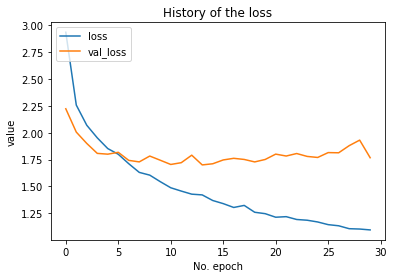

In [ ]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('History of the loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig('/content/drive/MyDrive/DL/Project/resnet_loss.png')
plt.show()

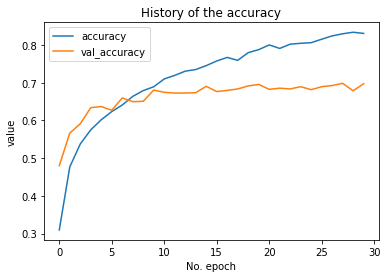

In [ ]:
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title('History of the accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig('/content/drive/MyDrive/DL/Project/resnet_acc.png')
plt.show()

The graphs also shows appropirate patterns.
Here we can also accept H1, because even the imbalanced data we have good training and generalization pattern. We are going to save the model and see how good it is in predicting a new, unseen data . 

In [ ]:
model.save('/content/drive/MyDrive/DL/Project/resnet.hdf5')

### Now we will load the last split with the test data .

In [8]:
model = load_model('/content/drive/MyDrive/DL/Project/resnet.hdf5')

In [9]:
x = []
with open(PIK4, "rb") as f:
    for i in range(pickle.load(f)):
        x.append(pickle.load(f))
y = []
with open(PIK5, "rb") as f:
    for i in range(pickle.load(f)):
        y.append(pickle.load(f))

In [10]:
data_test=np.array(x)

In [12]:
y = np.array(y)

In [13]:
y[y=='Achaemenid architecture']=0
y[y=='American Foursquare architecture']=1
y[y=='American craftsman style']=2
y[y=='Ancient Egyptian architecture']=3
y[y=='Art Deco architecture']=4
y[y=='Art Nouveau architecture']=5
y[y=='Baroque architecture']=6
y[y=='Bauhaus architecture']=7
y[y=='Beaux-Arts architecture']=8
y[y=='Byzantine architecture']=9
y[y=='Chicago school architecture']=10
y[y=='Colonial architecture']=11
y[y=='Deconstructivism']=12
y[y=='Edwardian architecture']=13
y[y=='Georgian architecture']=14
y[y=='Gothic architecture']=15
y[y=='Greek Revival architecture']=16
y[y=='International style']=17
y[y=='Novelty architecture']=18
y[y=='Palladian architecture']=19
y[y=='Postmodern architecture']=20
y[y=='Queen Anne architecture']=21
y[y=='Romanesque architecture']=22
y[y=='Russian Revival architecture']=23
y[y=='Tudor Revival architecture']=24

In [14]:
labels_test = y.astype(int)

In [15]:
labels_test = to_categorical(labels_test)

In [16]:
Y_pred = model.predict(data_test)
y_pred = np.argmax(Y_pred, axis=1)

In [18]:
y_test = np.argmax(labels_test, axis=1)

In [19]:
print('Classification Report')
target_names = styles
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
                                  precision    recall  f1-score   support

         Achaemenid architecture       0.56      0.74      0.64        46
American Foursquare architecture       0.45      0.76      0.56        45
        American craftsman style       0.47      0.28      0.35        32
   Ancient Egyptian architecture       0.80      0.81      0.81        54
           Art Deco architecture       0.67      0.20      0.31        20
        Art Nouveau architecture       0.24      0.67      0.36        12
            Baroque architecture       0.48      0.56      0.52        50
            Bauhaus architecture       0.90      0.84      0.87        32
         Beaux-Arts architecture       0.31      0.19      0.24        42
          Byzantine architecture       0.54      0.48      0.51        27
     Chicago school architecture       0.71      0.56      0.63        27
           Colonial architecture       0.40      0.48      0.44        66
               

The scores for the different classes are varying. This again show the difficulty of our data, but lets see it visualy . 

Confusion matrix, without normalization


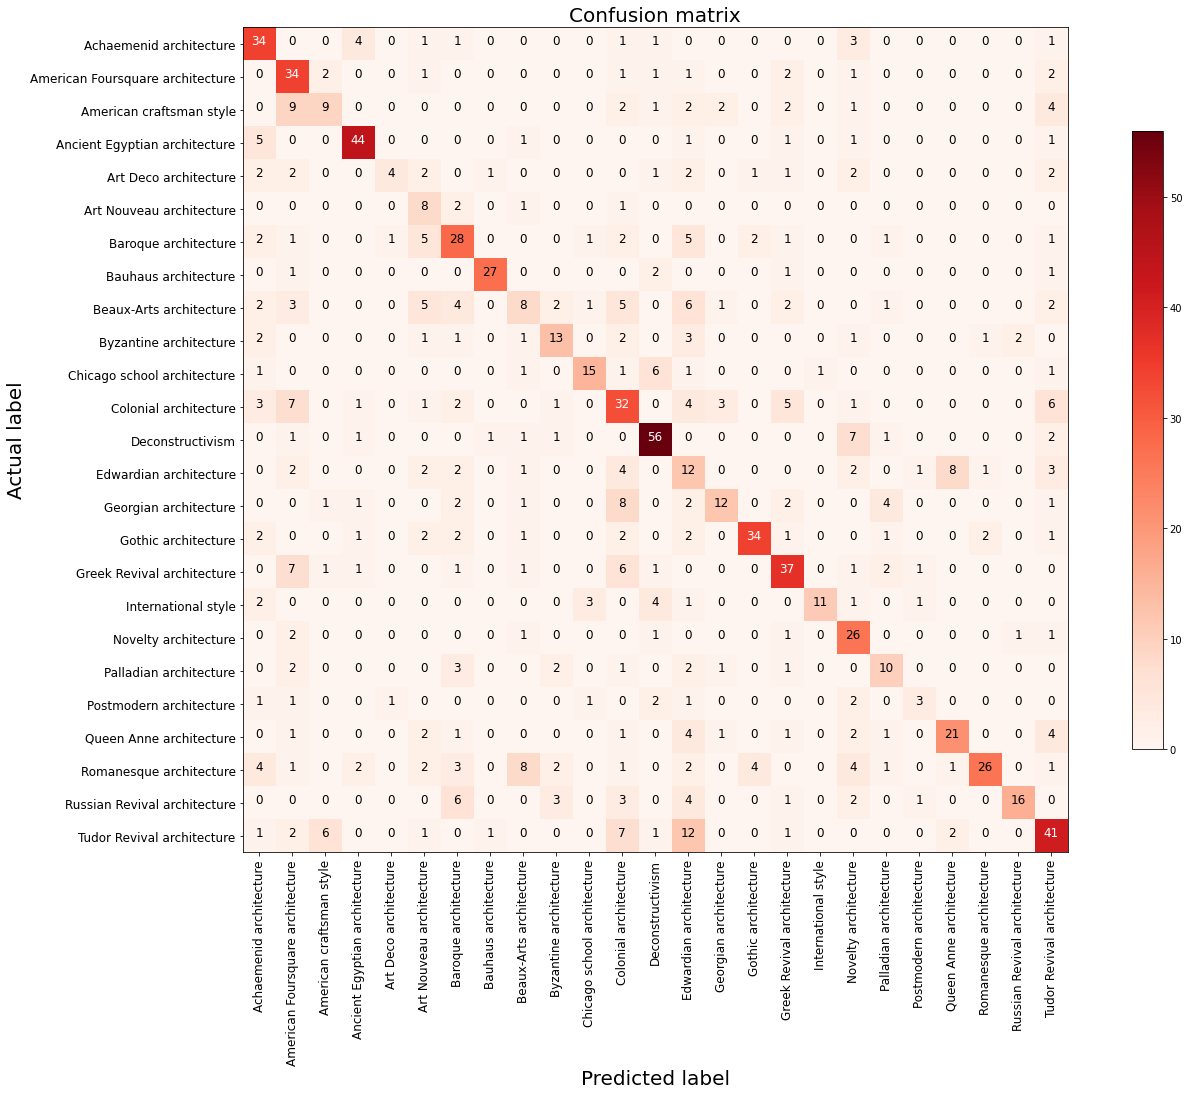

In [20]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(20, 15))
plot_confusion_matrix(cm, classes=styles)
plt.show()

### The true predictions are in appropriate diagonal trend. Now we will check if Inception can show better results. 